# Sentiment analysis of the spread of hate in tweets using RNN

## 1. Understanding the Problem Statement

Twitter is one of the biggest and most popular social networks with around 300 million users, 40% of which are active on the platform multiple times per day. Hence, it’s understandable the need to monitor the sentiment of the users, especially if it can help stop the spread of hateful and damaging massages. 

The goal of our project is to reproduce the original project and to replicate the results using the dataset described below, with the aim of building a robust model for predicting hate tweets. The model is based on Recurrent Neural Networks (RNNs), with the implementation and evaluation of different layers such as LSTM, GRU. Furthermore, we used pretrained word vectors from GloVe model trained with tweets, which is loaded in our model in an Embedding layer.

## 2. About the dataset

The data used was found on Kaggle: 

https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset

The dataset used to build and evaluate the model contains 56,744 rows and three columns: 
    
    id - ID assigned to each tweet
    label - 1 if the tweeter is considered hateful and 0 non-hateful
    tweet - string containing tweet’s text.
    


## 3. Import Libraries

In [ ]:
# Import modules

import numpy
import numpy as np
from numpy.random import seed

import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import inspect
import tensorflow
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

## 4. Read and Inspect the Data

In [ ]:
data_columns = ["ids","label","tweet"]
tweets= pd.read_csv('training.csv', names=data_columns)[1:]
tweets.head()

,ids,label,tweet
1,0.0,0,@user when a father is dysfunctional and is s...
2,1.0,0,@user @user thanks for #lyft credit i can't us...
3,2.0,0,bihday your majesty
4,3.0,0,#model i love u take with u all the time in ...
5,4.0,0,factsguide: society now #motivation


In [ ]:
tweets["label"].replace({"0": 0, "1": 1}, inplace=True)

In [ ]:
np.unique(tweets.label)

array([0, 1])

In [ ]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (tweets.label == 1).sum(),
    (tweets.label == 0).sum()
))

Hatred labeled: 24153
Non-hatred labeled: 32592


## 5. Text Cleaning and Preprocessing

In [ ]:
# remove URL's and @users
tweets['clean_tweet'] = tweets['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: re.sub(r'&#\S+', '', x))
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: re.sub('@[a-zA-Z0-9_]+', '', x))

In [ ]:
#Removing hashtags and creating hashtags column
hashtags = tweets['clean_tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
tweets.loc[:, 'hashtags'] = hashtags['hashtag']
tweets['hashtags'].fillna('', inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [ ]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
tweets['clean_tweet'] = tweets['clean_tweet'].str.lower()

# remove numbers
tweets['clean_tweet'] = tweets['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x:' '.join(x.split()))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Lemmatizing tweets

#!pip3 install -U spacy
#!python3 -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [ ]:
tweets['clean_tweet'] = lemmatization(tweets['clean_tweet'])

In [ ]:
#Removing whatever non-character rest that could remain in the tweets

tweets['clean_tweet2'] = tweets.clean_tweet.str.replace('[^a-zA-Z]', ' ')
#tweets['lwords'] = tweets['clean_tweet2'].apply(lambda x: x.split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
tweets.sample(50)

,ids,label,tweet,clean_tweet,hashtags,clean_tweet2
3020,3019.0,1,#texas the principal resigned! #justicereform...,texas the principal resign justicereform the p...,texas justicereform,texas the principal resign justicereform the p...
30901,30900.0,1,@user #allahsoil culture is like the horizonâ...,allahsoil culture be like the horizonâalways...,allahsoil,allahsoil culture be like the horizon always...
46268,46267.0,1,RT @BandWorld1 That bitch who the shit in yo e...,rt that bitch who the shit in yo eye be not sh...,,rt that bitch who the shit in yo eye be not sh...
52328,52327.0,1,RT @xM_3Times: Yung nation- riot . Still bump ...,rt yung nation riot . still bump that hoe,,rt yung nation riot still bump that hoe
9255,9254.0,0,@user hi @user my friend #lokiday for you,hi -PRON- friend lokiday for -PRON-,lokiday,hi PRON friend lokiday for PRON
40462,40461.0,1,Coke and white bitches.,coke and white bitch .,,coke and white bitch
22604,22603.0,0,#my bihday friday. princess eden deserves #gif...,-PRON- bihday friday . princess eden deserve g...,my gifts spoilt,PRON bihday friday princess eden deserve g...
17171,17170.0,0,i am thankful for happiness. #thankful #positi...,i be thankful for happiness . thankful positive,thankful positive,i be thankful for happiness thankful positive
17869,17868.0,0,cheers! it's #friday ya'll! happy hours are al...,cheer -PRON- be friday ya'll happy hour be alw...,friday,cheer PRON be friday ya ll happy hour be alw...
12416,12415.0,0,i am thankful for clothes. #thankful #positive...,i be thankful for clothe . thankful positive,thankful positive,i be thankful for clothe thankful positive


In [ ]:
pd.set_option("display.max_colwidth", -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


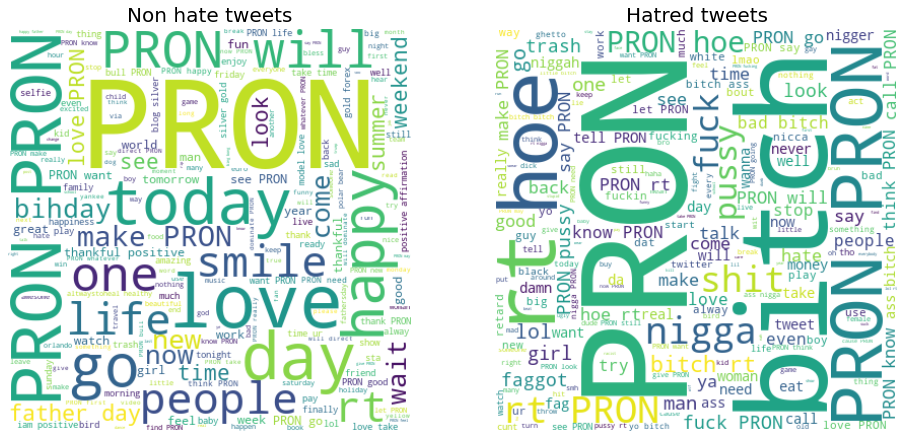

In [ ]:
#Most used words

stopwords = STOPWORDS.add('amp')

nonhate_words = ' '.join(tweets[tweets.label == 0].clean_tweet2.values)
hatred_words = ' '.join(tweets[tweets.label == 1].clean_tweet2.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(nonhate_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Non hate tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

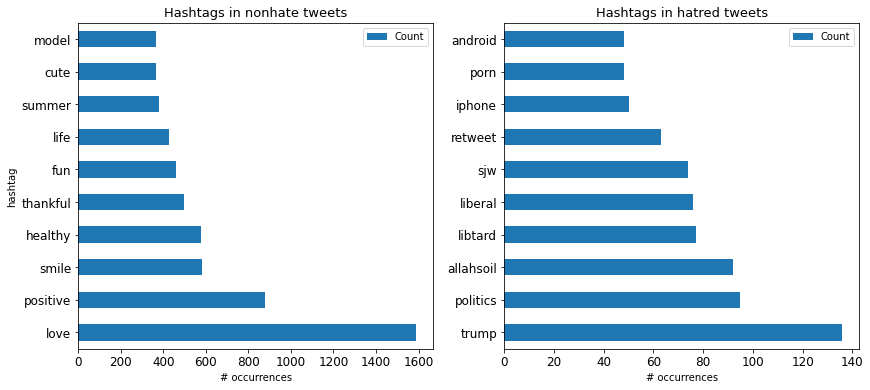

In [ ]:
#Most used hashtags

nonhate_hashtags = FreqDist(list(' '.join(tweets[tweets.label==0].hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(tweets[tweets.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(nonhate_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in nonhate tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

In [ ]:
#Splitting the data in 80% train and 20% test

X_train, X_test, Y_train, Y_test = train_test_split(list(tweets.clean_tweet2), list(tweets.label),test_size=0.2, random_state=42)

## 6. Pretrained word vectors

### Global Vectors for Word Representation (GloVe)
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm developed by researchers at Stanford University aiming to generate word embeddings (vector representations for words). Its training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space which have the potential for encoding some form of meaning. It's essentially a log-bilinear model with a weighted least-squares objective.

#### Pre-trained GloVe word vectors used:

Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [ ]:
#Crating glove dictionary from downloaded pre-trained GloVe word vectors

def get_glove_vectors(filename="glove.twitter.27B.200d.txt"):
    # Get all word vectors from pre-trained model
    glove_vector_dict = {}
    with open(filename) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
    
    return glove_vector_dict

In [ ]:
glove_dict=get_glove_vectors()

In [ ]:
#Encoding vocabulary from training tweets

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'be': 1, 'i': 2, 'the': 3, 'a': 4, 'to': 5, 'you': 6, 'bitch': 7, 'not': 8, 'and': 9, 'in': 10, 'rt': 11, 'my': 12, 'of': 13, 'for': 14, 'do': 15, 'that': 16, 'it': 17, 'on': 18, 'get': 19, 'this': 20, 'have': 21, 'with': 22, 'hoe': 23, 'all': 24, 'like': 25, 'love': 26, 'so': 27, 'day': 28, 'they': 29, 'your': 30, 'can': 31, 'we': 32, 'just': 33, 'at': 34, 'go': 35, 's': 36, 'when': 37, 'but': 38, 'up': 39, 'amp': 40, 'u': 41, 'pussy': 42, 'he': 43, 'she': 44, 'what': 45, 'if': 46, 'no': 47, 'make': 48, 'good': 49, 'will': 50, 'out': 51, 'happy': 52, 'fuck': 53, 'time': 54, 'about': 55, 'see': 56, 'these': 57, 'from': 58, 'as': 59, 'ass': 60, 'how': 61, 'say': 62, 'now': 63, 'one': 64, 'life': 65, 'want': 66, 'know': 67, 'look': 68, 'shit': 69, 'who': 70, 'today': 71, 'some': 72, 'take': 73, 'lol': 74, 'girl': 75, 'new': 76, 'people': 77, 'think': 78, 'nigga': 79, 'need': 80, 'come': 81, 'or': 82, 'by': 83, 'trash': 84, 'more': 85, 'well': 86, 'why': 87, 'his': 88, 'man': 89, 'an': 9

In [ ]:
#Number of words in our vocabulary

len(tokenizer.word_index)

38709

In [ ]:
# Filter GLoVE vectors to our specific vocabulary

def filter_glove(vocabulary_dict, glove_dict, wordvec_dim):
    # Create a matrix to store the vectors
    embedding_matrix = np.zeros((len(vocabulary_dict) + 1, wordvec_dim))
    for word,i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
glove_matrix = filter_glove(vocabulary_dict=tokenizer.word_index,glove_dict=glove_dict,wordvec_dim=200)
print(glove_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.72794002  0.41955999 -0.28589001 ... -0.1469     -0.035087
  -0.022335  ]
 [ 0.056404    0.49535999  0.18438999 ...  0.63598001 -0.18880001
  -0.035558  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
len(glove_matrix)

38710

## 7. Prepare the (X, Y) variables to fit the model

In [ ]:
# Change texts into sequence of indexes
train_numeric = tokenizer.texts_to_sequences(X_train)
test_numeric = tokenizer.texts_to_sequences(X_test)

In [ ]:
for i in range(3):
    print('\n',train_numeric[i],"\n\n",len(train_numeric[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [13, 172, 1, 660, 2223, 121, 13, 863, 114, 57, 23, 1, 145] 

 13 

 ['of', 'woman', 'be', 'slut', 'freshman', 'year', 'of', 'college', 'let', 'these', 'hoe', 'be', 'great'] 

 13 

********************** 0

 [14598, 14599, 304, 165, 92, 5, 14600, 3, 4161, 14601, 299, 102, 108, 93, 1, 220, 4571, 1076, 10, 3, 1495, 5, 2728, 43] 

 24 

 ['kip', 'tokuda', 'yellow', 'guy', 'work', 'to', 'niggerize', 'the', 'seattle', 'pd', 'die', 'too', 'bad', 'there', 'be', 'another', 'pos', 'hide', 'in', 'the', 'wing', 'to', 'replace', 'he'] 

 24 

********************** 1

 [421, 40, 1, 14602, 14603] 

 5 

 ['laugh', 'amp', 'be', 'positip', 'plusfactorph'] 

 5 

********************** 2


In [ ]:
# Largest tweet

largest=0
for i in range(len(train_numeric)):
    largest=max(largest,len(train_numeric[i]))
for i in range(len(test_numeric)):
    largest=max(largest,len(test_numeric[i]))
    
print(largest)

37


In [ ]:
# Pad the sequences
train_pad = pad_sequences(train_numeric, largest)
test_pad = pad_sequences(test_numeric, largest)
Y_train = numpy.array(Y_train)
Y_test = numpy.array(Y_test)

In [ ]:
for i in range(3):
    print('\n',train_pad[i],"\n\n",len(train_pad[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   13  172    1  660
 2223  121   13  863  114   57   23    1  145] 

 37 

 ['of', 'woman', 'be', 'slut', 'freshman', 'year', 'of', 'college', 'let', 'these', 'hoe', 'be', 'great'] 

 13 

********************** 0

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0 14598 14599   304   165    92     5 14600     3  4161 14601   299
   102   108    93     1   220  4571  1076    10     3  1495     5  2728
    43] 

 37 

 ['kip', 'tokuda', 'yellow', 'guy', 'work', 'to', 'niggerize', 'the', 'seattle', 'pd', 'die', 'too', 'bad', 'there', 'be', 'another', 'pos', 'hide', 'in', 'the', 'wing', 'to', 'replace', 'he'] 

 24 

********************** 1

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   